In [1]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pprint import pprint

In [2]:
# Psycopg2 is a popular PostgreSQL adapter for the Python programming language. It allows Python code to interact with PostgreSQL databases. 
import psycopg2
from psycopg2 import sql

# Import the time module so we can time our queries.
import time

# Amazon SageMaker and related imports
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sagemaker import get_execution_role
from sagemaker import image_uris
import boto3  # AWS Python sdk

%matplotlib inline

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\Fer\AppData\Local\sagemaker\sagemaker\config.yaml


In [3]:
#Info for the connection wiht postgres SQL in RDS
PGEND_POINT = 'database-1.cfwmkaw8o6bp.us-east-1.rds.amazonaws.com' #End Point
PGDATABASE_NAME ='heart_attack_prediction_db' #data base name 
PGUSER_NAME = 'postgres'
PGPASSWORD = 'B00TC4MP'

In [4]:
#Defining functions for connection and close connection
def connect():
    conn_string = f"host={PGEND_POINT} port=5432 dbname={PGDATABASE_NAME} user={PGUSER_NAME} password={PGPASSWORD}"
    conn = psycopg2.connect(conn_string)
    print("Connected!")
    
    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

#Close connection function definition
def close_connection(conn, cursor):
    conn.commit()
    cursor.close()
    conn.close()
    print("Connection closed.")

In [5]:
#Creting the connection with postgres SQL
conn, cursor = connect()

Connected!


In [6]:
#SQL SELECT statement that retrieves all columns (*) from the table named heartattackprediction.
query_hat_all = sql.SQL("""
SELECT * FROM heartattackcapitals;
""")

In [7]:
#Preparation of the database cursor to execute the SQL query specified by query_hat_all. 
#Once the query is executed, the cursor will hold the result set (if any) 
#returned by the database server.
cur = conn.cursor()
cur.execute(query_hat_all)

In [8]:
#put all the data in heartattackprediction table into a data frame in pandas all the columns name appear
pd_df = pd.DataFrame(cur.fetchall(), columns=['Country','Capital','Patient ID', 'Age', 'Sex','Cholesterol', 'Blood Pressure','Heart Rate','Diabetes','Family History','Smoking','Obesity','Alcohol Consumption','Exercise Hours Per Week','Diet','Previous Heart Problems','Medication Use','Stress Level','Sedentary Hours Per Day','Income','BMI','Triglycerides','Physical Activity Days Per Week','Sleep Hours Per Day','Country','Continent','Hemisphere','Heart Attack Risk', 'lat', 'long'])
pd_df.head(5)

,Country,Capital,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk,lat,long
0,Argentina,Buenos Aires,BMW7812,67,1,208,72,0,0,1,...,286,0,6,South America,1,0,-34.0,-64.0,158,88
1,Argentina,Buenos Aires,SLE3369,27,0,135,49,1,1,0,...,297,1,10,South America,1,1,-34.0,-64.0,120,77
2,Argentina,Buenos Aires,IUJ5442,27,0,263,83,0,1,0,...,411,2,9,South America,1,0,-34.0,-64.0,127,109
3,Argentina,Buenos Aires,BSV5917,29,0,201,86,0,0,0,...,785,0,10,South America,1,0,-34.0,-64.0,134,60
4,Argentina,Buenos Aires,QWD3129,51,1,197,79,1,1,1,...,785,1,5,South America,1,0,-34.0,-64.0,106,106


In [9]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [10]:
#Trial Data
data = pd.read_csv("Resources/NCdata-5years-survival-trends-pop(578,752,246,208,352)-can(180)-females-p(5).csv", header=0, index_col=0)
data = data.T

In [11]:
data

Label,Denmark,Finland,Iceland,Norway,Sweden
1971-1975,61.2,59.3,72.1,65.0,67.4
1976-1980,66.1,64.0,75.7,70.2,74.9
1981-1985,66.6,71.4,75.6,73.2,76.6
1986-1990,70.4,77.8,77.1,75.2,80.0
1991-1995,74.5,80.5,80.8,76.8,82.8
1996-2000,78.8,84.3,86.9,84.0,85.5
2001-2005,82.5,86.4,86.1,85.2,86.7
2006-2010,86.2,88.4,89.3,86.5,89.6
2011-2015,89.6,90.2,87.2,89.9,91.7
2016-2020,90.2,90.8,91.2,90.8,92.3


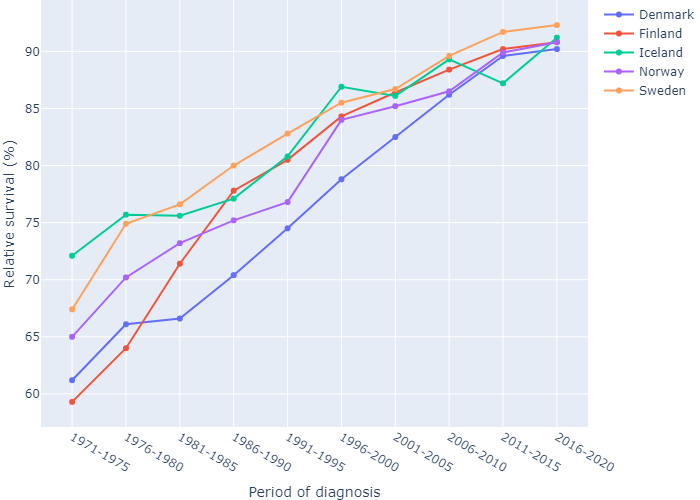

In [12]:
figures = []

#Processing the data
for country in data.columns:
    figures.append(
        go.Scatter(
            name=country,
            x=data.index,
            y=data[country],
            mode='markers+lines',
            showlegend=True,
        )
    )
#Establishing the axis titles
layout = go.Layout(
    xaxis=dict(
        title="Period of diagnosis"
    ),
    yaxis=dict(
        title="Relative survival (%)"
    )
)

#Establishing the figure margins
fig = go.Figure(figures, layout=layout)
fig.update_layout(
    margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin  <- Need to be adjusted if title is added!
    )
)

#Creating a new 
os.makedirs("results/", exist_ok=True)

#Saving results image as a png file
fig.show(renderer="png")
fig.write_image("results/breast_cancer_survival.png")

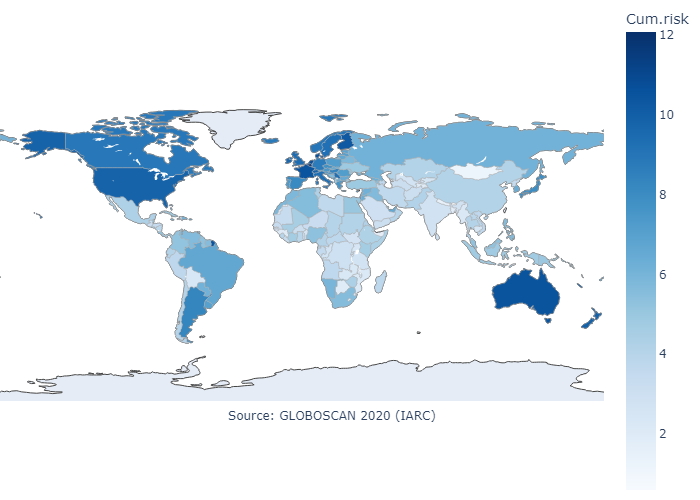

In [13]:
cancer_data = pd.read_csv("Resources/cum_risk_breast_cancer_incidence.csv")

fig = go.Figure(data=go.Choropleth(
    locations = cancer_data['ISO code'],
    z = cancer_data['Value'],
    text = cancer_data['Population'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    #colorbar_tickprefix = '%',
    colorbar_title = 'Cum.risk',
))

fig.update_layout(
    #title_text='Estimated cumulative risk of breast cancer mortality in 2020, females, ages 0-74',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.15,
        xref='paper',
        yref='paper',
        text='Source: GLOBOSCAN 2020 (IARC)',
        showarrow = False
    )],
    margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin  <- Need to be adjusted if title is added!
    )
)

os.makedirs("results/", exist_ok=True)

fig.show(renderer="png")
fig.write_image("results/cum_risk_breast_cancer_incidence.svg")


In [14]:
data_df = pd_df
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          8763 non-null   object 
 1   Capital                          8763 non-null   object 
 2   Patient ID                       8763 non-null   object 
 3   Age                              8763 non-null   int64  
 4   Sex                              8763 non-null   object 
 5   Cholesterol                      8763 non-null   int64  
 6   Blood Pressure                   8763 non-null   int64  
 7   Heart Rate                       8763 non-null   int64  
 8   Diabetes                         8763 non-null   int64  
 9   Family History                   8763 non-null   int64  
 10  Smoking                          8763 non-null   int64  
 11  Obesity                          8763 non-null   int64  
 12  Alcohol Consumption 

In [15]:
data_df = pd.read_csv("Resources/final_data.csv")
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          8763 non-null   object 
 1   Capital                          8763 non-null   object 
 2   Patient ID                       8763 non-null   object 
 3   Age                              8763 non-null   int64  
 4   Sex                              8763 non-null   int64  
 5   Cholesterol                      8763 non-null   int64  
 6   Heart Rate                       8763 non-null   int64  
 7   Diabetes                         8763 non-null   int64  
 8   Family History                   8763 non-null   int64  
 9   Smoking                          8763 non-null   int64  
 10  Obesity                          8763 non-null   int64  
 11  Alcohol Consumption              8763 non-null   int64  
 12  Exercise Hours Per W

In [16]:
data_df

,Country,Capital,Patient ID,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Continent,Hemisphere,Heart Attack Risk,lat,long,Systolic Pressure,Diastolic Pressure
0,Argentina,Buenos Aires,BMW7812,67,1,208,72,0,0,1,...,286,0,6,South America,1,0,-34.0,-64.0,158,88
1,Argentina,Buenos Aires,SLE3369,27,0,135,49,1,1,0,...,297,1,10,South America,1,1,-34.0,-64.0,120,77
2,Argentina,Buenos Aires,IUJ5442,27,0,263,83,0,1,0,...,411,2,9,South America,1,0,-34.0,-64.0,127,109
3,Argentina,Buenos Aires,BSV5917,29,0,201,86,0,0,0,...,785,0,10,South America,1,0,-34.0,-64.0,134,60
4,Argentina,Buenos Aires,QWD3129,51,1,197,79,1,1,1,...,785,1,5,South America,1,0,-34.0,-64.0,106,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,Vietnam,Hanoi,QWP9633,88,1,394,51,1,0,1,...,79,7,9,Asia,0,0,16.0,106.0,112,62
8759,Vietnam,Hanoi,AZG4713,45,0,368,87,1,0,1,...,564,2,5,Asia,0,0,16.0,106.0,180,94
8760,Vietnam,Hanoi,WAO3408,85,1,200,65,1,1,1,...,214,1,10,Asia,0,1,16.0,106.0,167,101
8761,Vietnam,Hanoi,WFO1019,29,1,280,90,1,1,1,...,423,5,5,Asia,0,0,16.0,106.0,106,107


In [17]:
mean_chol_continent = data_df.groupby('Continent')['Cholesterol'].mean()
chol_continent = pd.DataFrame(mean_chol_continent).reset_index()

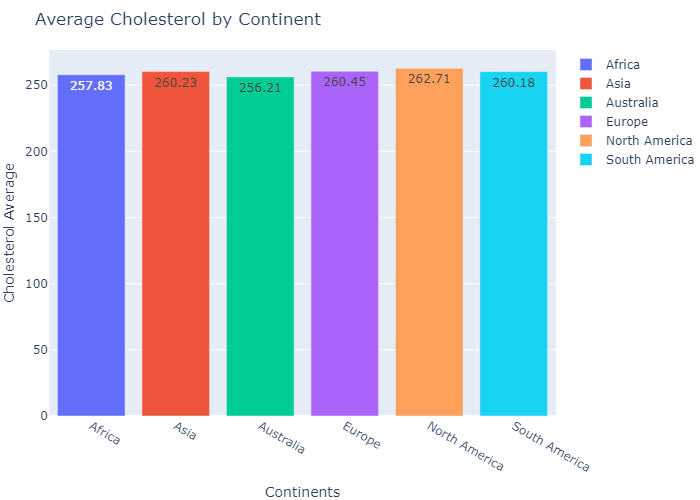

In [18]:
# Processing the data
visuals = []
for index, row in chol_continent.iterrows():
    visuals.append(
        go.Bar(
            name=row['Continent'],
            x=[row['Continent']],  # Using a list for x to make it a column-like representation
            y=[row['Cholesterol']],  # Using a list for y to make it a column-like representation
            text=[f"{row['Cholesterol']:.2f}"],  # Displaying values with two decimal places
            textposition='auto',  # Automatically position the text on
            showlegend=True,
        )
    )

# Establishing the axis titles
layout = go.Layout(
    title="Average Cholesterol by Continent",
    xaxis=dict(
        title="Continents"
    ),
    yaxis=dict(
        title="Cholesterol Average",
    )
)

# Establishing the figure margins
vis = go.Figure(visuals, layout=layout)
vis.update_layout(
    margin=go.layout.Margin(
        l=0,  # left margin
        r=0,  # right margin
        b=0,  # bottom margin
        t=50   # top margin  <- Need to be adjusted if title is added!
    )
)

# Creating a new directory if not exists
os.makedirs("results/", exist_ok=True)

# Saving results image as a png file
vis.show(renderer="png")
vis.write_image("results/heart_attack_rates_2.png")

In [19]:
mean_tri_continent = data_df.groupby('Continent')['Triglycerides'].mean()
tri_continent = pd.DataFrame(mean_tri_continent).reset_index()

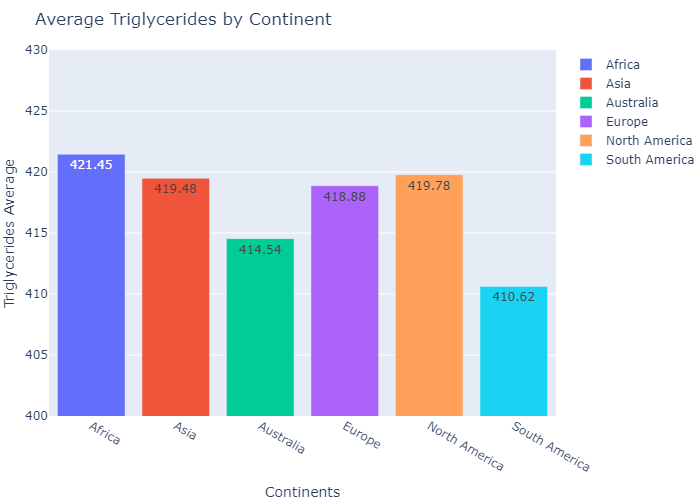

In [20]:
# Processing the data
visuals = []
for index, row in tri_continent.iterrows():
    visuals.append(
        go.Bar(
            name=row['Continent'],
            x=[row['Continent']],  # Using a list for x to make it a column-like representation
            y=[row['Triglycerides']],  # Using a list for y to make it a column-like representation
            text=[f"{row['Triglycerides']:.2f}"],  # Displaying values with two decimal places
            textposition='auto',  # Automatically position the text on
            showlegend=True,
        )
    )

# Establishing the axis titles
layout = go.Layout(
    title="Average Triglycerides by Continent",
    xaxis=dict(
        title="Continents"
    ),
    yaxis=dict(
        title="Triglycerides Average",
        range=[400, 430]
    )
)

# Establishing the figure margins
vis = go.Figure(visuals, layout=layout)
vis.update_layout(
    margin=go.layout.Margin(
        l=0,  # left margin
        r=0,  # right margin
        b=0,  # bottom margin
        t=50   # top margin  <- Need to be adjusted if title is added!
    )
)

# Creating a new directory if not exists
os.makedirs("results/", exist_ok=True)

# Saving results image as a png file
vis.show(renderer="png")
vis.write_image("results/heart_attack_rates.png")

In [21]:
chol_tri_continent = pd.merge(tri_continent, chol_continent, on='Continent', how='inner')
chol_tri_continent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Continent      6 non-null      object 
 1   Triglycerides  6 non-null      float64
 2   Cholesterol    6 non-null      float64
dtypes: float64(2), object(1)
memory usage: 272.0+ bytes


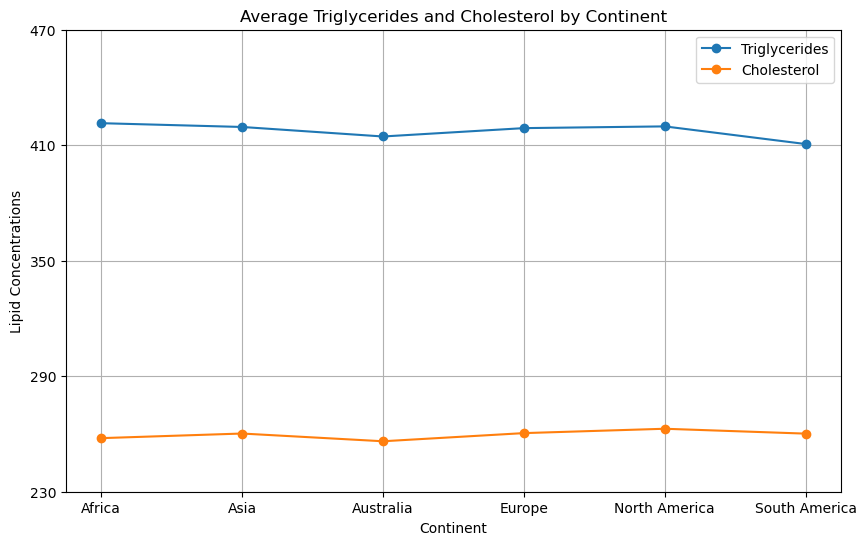

In [22]:
# Plotting the double line graph
axis = chol_tri_continent.plot(x='Continent', y=['Triglycerides', 'Cholesterol'], kind='line', marker='o')

# Adding labels and title
plt.xlabel('Continent')
plt.ylabel('Lipid Concentrations')
plt.title('Average Triglycerides and Cholesterol by Continent')

#Changing the scale of the graph
plt.gcf().set_size_inches(10, 6) 
axis.yaxis.set_ticks([230, 290, 350, 410, 470])
axis.set_xticks(chol_tri_continent.index)
axis.grid(True)

# Display the plot
plt.savefig('results/lipids.png')
plt.show()

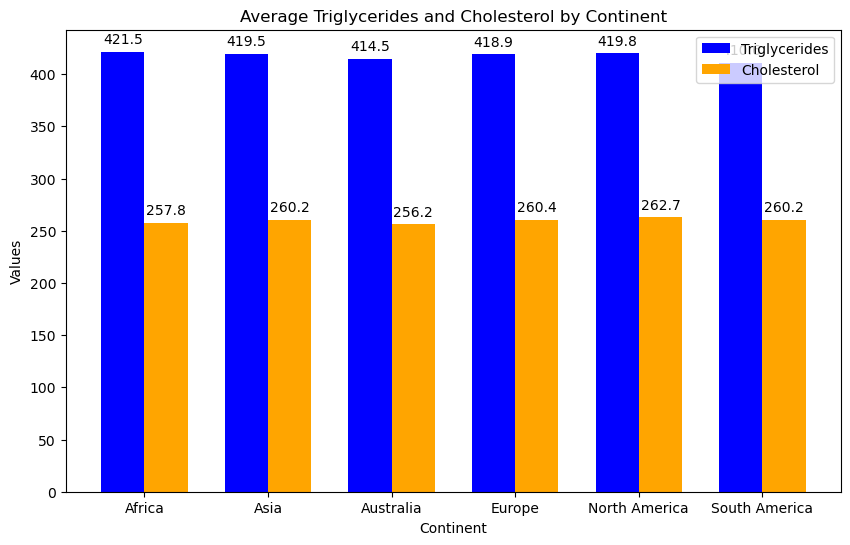

In [23]:
# Creating a double bar graph for Triglycerides and Cholesterol
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35  # Width of each bar
index = np.arange(len(chol_tri_continent['Continent']))

# Bar graph for Triglycerides
ax.bar(index, chol_tri_continent['Triglycerides'], width=bar_width, label='Triglycerides', color='blue')

# Bar graph for Cholesterol
ax.bar(index + bar_width, chol_tri_continent['Cholesterol'], width=bar_width, label='Cholesterol', color='orange')

# Adding values on top of each bar
for i, value in enumerate(chol_tri_continent['Triglycerides']):
    plt.text(i, value + 5, round(value, 1), ha='center', va='bottom', color='black')

for i, value in enumerate(chol_tri_continent['Cholesterol']):
    plt.text(i + bar_width, value + 5, round(value, 1), ha='center', va='bottom', color='black')

# Adding labels and title
ax.set_xlabel('Continent')
ax.set_ylabel('Values')
ax.set_title('Average Triglycerides and Cholesterol by Continent')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(chol_tri_continent['Continent'])
ax.legend()


In [24]:
#Making a df to make the map with folium which requires list inputs since it doesn't take pandas dataframes
selected_columns = ['Capital', 'lat', 'long']
capitals_place = pd_df[selected_columns]

#Cleaning up
average_location_lat = capitals_place.groupby('Capital')['lat'].mean()
average_location_long = capitals_place.groupby('Capital')['long'].mean()
average_location = pd.merge(average_location_lat, average_location_long, on = 'Capital', how = 'inner')
average_location


,lat,long
Capital,,
Abuja,134.526786,85.314732
Bangkok,137.007009,84.427570
Beijing,134.830275,84.199541
Berlin,133.566038,84.685535
Bogota,136.027972,85.713287
Brasilia,136.253247,85.324675
Buenos Aires,133.622081,85.951168
Canberra,135.405345,84.164811
Hanoi,136.538824,85.070588


In [25]:
coordinates = average_location.to_dict()
coordinates

{'lat': {'Abuja': 134.52678571428572,
  'Bangkok': 137.0070093457944,
  'Beijing': 134.8302752293578,
  'Berlin': 133.56603773584905,
  'Bogota': 136.02797202797203,
  'Brasilia': 136.25324675324674,
  'Buenos Aires': 133.6220806794055,
  'Canberra': 135.4053452115813,
  'Hanoi': 136.53882352941176,
  'London': 134.50109409190372,
  'Madrid': 135.36976744186046,
  'New Delhi': 133.47815533980582,
  'Ottawa': 134.8090909090909,
  'Paris': 135.54484304932734,
  'Pretoria': 134.24235294117648,
  'Rome': 135.59396751740138,
  'Seoul': 132.2762836185819,
  'Tokyo': 135.65357967667435,
  'Washington': 136.26904761904763,
  'Wellington': 136.0758620689655},
 'long': {'Abuja': 85.31473214285714,
  'Bangkok': 84.42757009345794,
  'Beijing': 84.19954128440367,
  'Berlin': 84.68553459119497,
  'Bogota': 85.7132867132867,
  'Brasilia': 85.32467532467533,
  'Buenos Aires': 85.95116772823779,
  'Canberra': 84.16481069042317,
  'Hanoi': 85.07058823529412,
  'London': 85.75054704595186,
  'Madrid': 85

In [44]:
selected_columns = ['Capital', 'lat', 'long', 'Triglycerides', 'Cholesterol']
tri_chol_map_df = pd_df[selected_columns]
tri_chol_map_df

,Capital,lat,long,Triglycerides,Cholesterol
0,Buenos Aires,158,88,0,208
1,Buenos Aires,120,77,1,135
2,Buenos Aires,127,109,2,263
3,Buenos Aires,134,60,0,201
4,Buenos Aires,106,106,1,197
...,...,...,...,...,...
8758,Hanoi,112,62,7,394
8759,Hanoi,180,94,2,368
8760,Hanoi,167,101,1,200
8761,Hanoi,106,107,5,280


In [45]:
#Cleaning up
average_tri_map = tri_chol_map_df.groupby('Capital')['Cholesterol'].mean()
average_chol_map = tri_chol_map_df.groupby('Capital')['Triglycerides'].mean()
tri_chol_map_df = pd.merge(average_tri_map, average_chol_map, on = 'Capital', how = 'inner')
tri_chol_map_df

,Cholesterol,Triglycerides
Capital,,
Abuja,262.205357,3.473214
Bangkok,262.137850,3.574766
Beijing,258.009174,3.614679
Berlin,258.060797,3.452830
Bogota,261.846154,3.501166
Brasilia,257.270563,3.402597
Buenos Aires,261.520170,3.316348
Canberra,258.997773,3.311804
Hanoi,264.418824,3.336471


In [26]:
import folium

In [48]:
tri_chol_mapping = pd.merge(tri_chol_map_df, average_location, on = 'Capital', how = 'inner')
tri_chol_mapping

,Cholesterol,Triglycerides,lat,long
Capital,,,,
Abuja,262.205357,3.473214,134.526786,85.314732
Bangkok,262.137850,3.574766,137.007009,84.427570
Beijing,258.009174,3.614679,134.830275,84.199541
Berlin,258.060797,3.452830,133.566038,84.685535
Bogota,261.846154,3.501166,136.027972,85.713287
Brasilia,257.270563,3.402597,136.253247,85.324675
Buenos Aires,261.520170,3.316348,133.622081,85.951168
Canberra,258.997773,3.311804,135.405345,84.164811
Hanoi,264.418824,3.336471,136.538824,85.070588


In [50]:
heart_trichol= tri_chol_mapping.to_dict()
heart_trichol

{'Cholesterol': {'Abuja': 262.20535714285717,
  'Bangkok': 262.1378504672897,
  'Beijing': 258.0091743119266,
  'Berlin': 258.0607966457023,
  'Bogota': 261.84615384615387,
  'Brasilia': 257.2705627705628,
  'Buenos Aires': 261.52016985138005,
  'Canberra': 258.9977728285078,
  'Hanoi': 264.4188235294118,
  'London': 259.8336980306346,
  'Madrid': 258.8558139534884,
  'New Delhi': 256.08009708737865,
  'Ottawa': 256.8477272727273,
  'Paris': 264.9484304932735,
  'Pretoria': 253.22588235294117,
  'Rome': 260.6658932714617,
  'Seoul': 259.6454767726161,
  'Tokyo': 260.96535796766744,
  'Washington': 268.85238095238094,
  'Wellington': 253.34022988505748},
 'Triglycerides': {'Abuja': 3.4732142857142856,
  'Bangkok': 3.574766355140187,
  'Beijing': 3.614678899082569,
  'Berlin': 3.452830188679245,
  'Bogota': 3.501165501165501,
  'Brasilia': 3.4025974025974026,
  'Buenos Aires': 3.316348195329087,
  'Canberra': 3.3118040089086858,
  'Hanoi': 3.336470588235294,
  'London': 3.654266958424507

In [53]:
my_map = folium.Map(location=[27.2546, 33.8116], zoom_start=2.3)

# Add markers for each city with popup showing cholesterol and triglycerides information
for city, lat in heart_trichol['lat'].items():
    long = heart_trichol['long'][city]
    cholesterol = heart_trichol['Cholesterol'][city]
    triglycerides = heart_trichol['Triglycerides'][city]

    popup_content = f'<b>{city}</b><br>Cholesterol: {cholesterol}<br>Triglycerides: {triglycerides}'
    folium.Marker(location=[lat, long], popup=popup_content).add_to(my_map)

# Save the map to an HTML file
my_map.save("cholesterol_triglycerides_map.html")